# Experiments for Predicting Long-Lived Bugs

# 1. Introduction 

This first experiment used a dataset with 7935 bug reports extracted from Eclipse Bugzilla Tracking System. The table below shows the evaluation performance metrics yielded.

## 1.1 Data Exploration

In [1]:
import pandas as pd
reports = pd.read_csv('~/Workspace/issue-crawler/data/eclipse/csv/r2_bug_report_data.csv')
reports = reports.loc[(reports['days-to-resolve'] >= 0) & (reports['days-to-resolve'] <= 730)  , ]
reports['resolution-code'] = reports['resolution-code'].astype('category')
reports['status-code'] = reports['status-code'].astype('category')
reports['severity-code'] = reports['severity-code'].astype('category')
reports.head(5)

,bug-id,created,component,product,summary,description,assignee,reporter,resolution,resolution-code,status,status-code,updated,votes,quantity-of-comments,resolved,days-to-resolve,severity,severity-code
0,COMMUNITY-455431,2014-12-17,Servers,COMMUNITY,Need SSH access to build.eclipse.org for uwe.s...,I'm a committer on the tools.cdt.tcf project a...,webmaster,uwe.st,fixed,1,resolved,4,2014-12-17,0,3,2014-12-17,0,normal,2
1,JDT-31738,2003-02-12,UI,JDT,Weird behavior setting project libraries,Open the properties for a project then Java Bu...,martinae,bogofilter+eclipse.org,fixed,1,resolved,4,2003-02-18,0,4,2003-02-18,6,normal,2
2,ORION-389073,2012-09-07,Git,ORION,Pull gives me an auth fail error without promp...,With the latest changes in git credentials (to...,simon_kaegi,susan,fixed,1,resolved,4,2012-09-12,0,7,2012-09-12,5,major,4
3,JETTY-306226,2010-03-17,client,JETTY,HttpClient should allow changing to the keysto...,(Originally JETTY-1190 @ Codehaus JIRA)\n\nCur...,mgorovoy,mgorovoy,fixed,1,resolved,4,2010-10-13,0,3,2010-05-12,56,normal,2
4,WTP_SOURCE_EDITING-185183,2007-05-02,wst.xsd,WTP_SOURCE_EDITING,Update copyright headers for WSDL and XSD comp...,Update copyright headers for WSDL and XSD comp...,kchong,kchong,fixed,1,closed,6,2007-07-05,0,4,2007-05-02,0,normal,2


### Basic Statistics

In [246]:
reports.describe(include="all")

,bug-id,created,component,product,summary,description,assignee,reporter,resolution,resolution-code,status,status-code,updated,votes,quantity-of-comments,resolved,days-to-resolve,severity,severity-code
count,11246,11246,11246,11246,11243,11063,11246,11246,11246,11246.0,11246,11246.0,11246,11246.000000,11246.000000,11246,11246.000000,11246,11246.0
unique,11246,4183,631,188,11200,10903,1609,3082,1,1.0,2,2.0,3770,NaN,NaN,4064,NaN,6,5.0
top,JETTY-472782,2001-10-10,UI,PLATFORM,Accessibility,,webmaster,david_williams,fixed,1.0,resolved,4.0,2016-05-05,NaN,NaN,2017-05-10,NaN,normal,2.0
freq,1,37,1302,1533,5,90,263,140,11246,11246.0,7578,7578.0,255,NaN,NaN,15,NaN,8876,9261.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025698,5.706829,NaN,68.605460,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351782,5.811217,NaN,131.934076,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,3.000000,NaN,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.000000,NaN,9.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,6.000000,NaN,63.000000,NaN,NaN


### Features Correlation

In [247]:
reports[['days-to-resolve', 'quantity-of-comments', 'votes']].corr()

,days-to-resolve,quantity-of-comments,votes
days-to-resolve,1.000000,0.160134,0.074449
quantity-of-comments,0.160134,1.000000,0.218668
votes,0.074449,0.218668,1.000000


### Severity Level Analysis

In [248]:
top_severity_level = reports.groupby('severity').severity.agg(['count'])
top_severity_level = top_severity_level.sort_values('count', ascending=False)[0:10]
top_severity_level

,count
severity,
normal,8876
major,1167
critical,425
minor,385
blocker,254
trivial,139


Text(0.5,0,'')

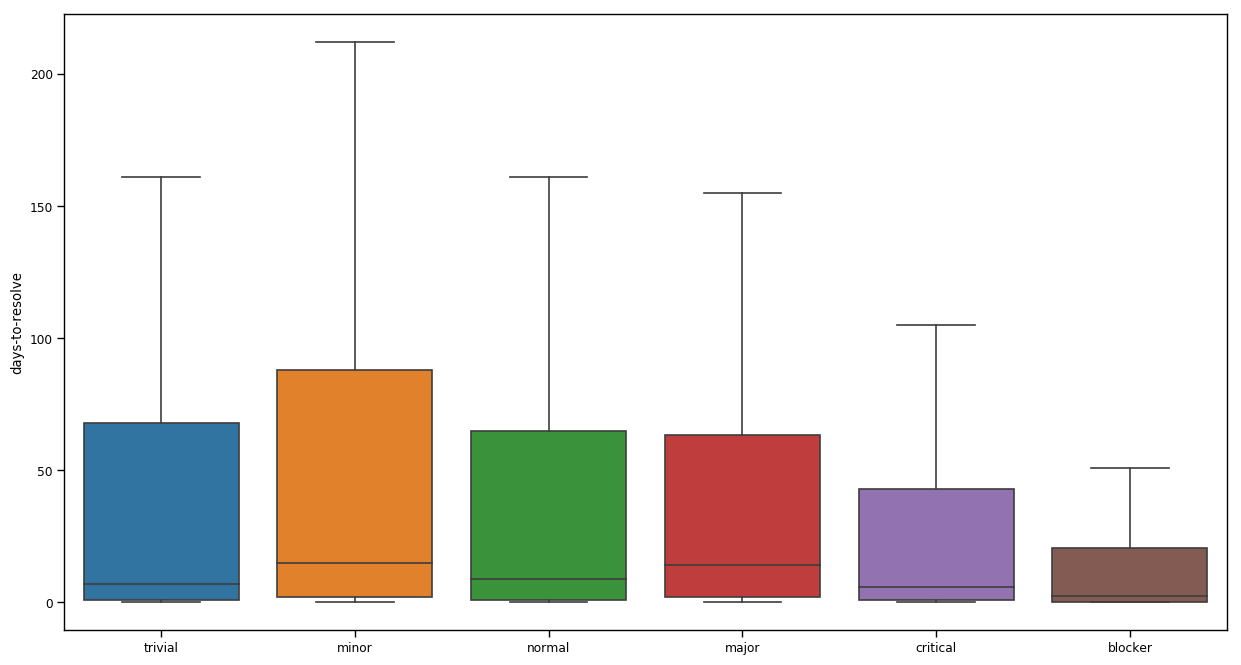

In [249]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
plt.style.use('default')
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=reports, x="severity", y="days-to-resolve"
                , order=['trivial', 'minor', 'normal', 'major', 'critical', 'blocker']
                , showfliers=False)
plt.xlabel("")

### Reporters Analysis

In [2]:
number_of_reports   = reports['bug-id'].count()
number_of_reporters = reports['reporter'].nunique()
print("%s reporters reported %s bugs." % (number_of_reporters, number_of_reports))

3082 reporters reported 11246 bugs.


In [3]:
top_10_reporters = reports.groupby('reporter').reporter.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter,
david_williams,140
john.arthorne,110
eclipse,109
wayne.beaton,96
markus.kell.r,95
pascal,84
daniel_megert,83
lchen,79
xwang,76


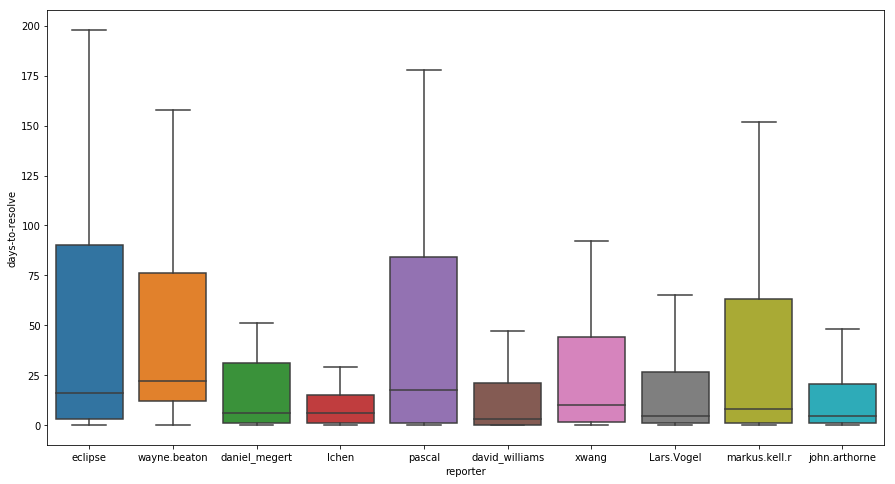

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['reporter'].isin(top_10_reporters.index)]
            , x="reporter"
            , y="days-to-resolve"
            , showfliers=False)

### Assignee Analysis

In [253]:
top_10_assignee = reports.groupby('assignee').assignee.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:10]
top_10_assignee

,count
assignee,
webmaster,263
rap-inbox,128
pde-ui-inbox,87
Silenio_Quarti,86
eclipse,85
emo,83
david_williams,80
john.arthorne,79
tmf.xtext-inbox,79


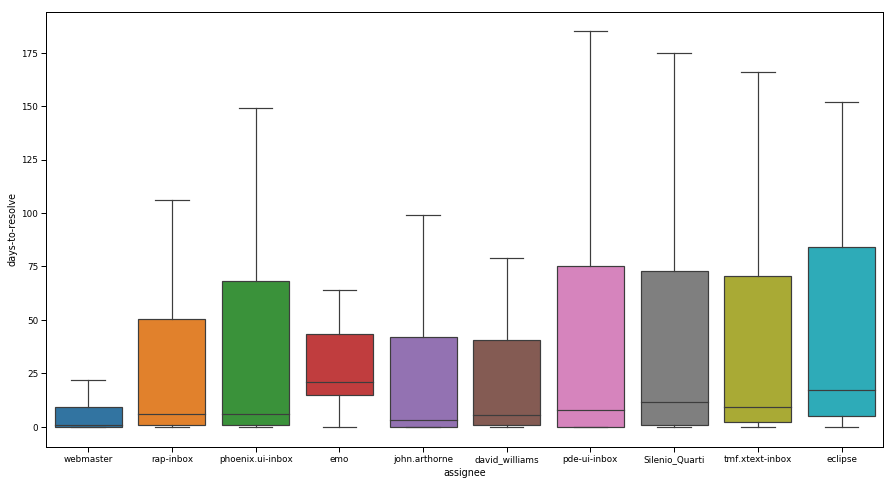

In [254]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['assignee'].isin(top_10_assignee.index)]
            , x="assignee"
            , y="days-to-resolve"
            , showfliers=False)

### Component Analysis

In [255]:
top_10_component = reports.groupby('component').component.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component,
UI,1302
Core,866
SWT,426
TPTP,251
Releng,220
General,216
cdt-core,186
Client,171
jst.j2ee,157


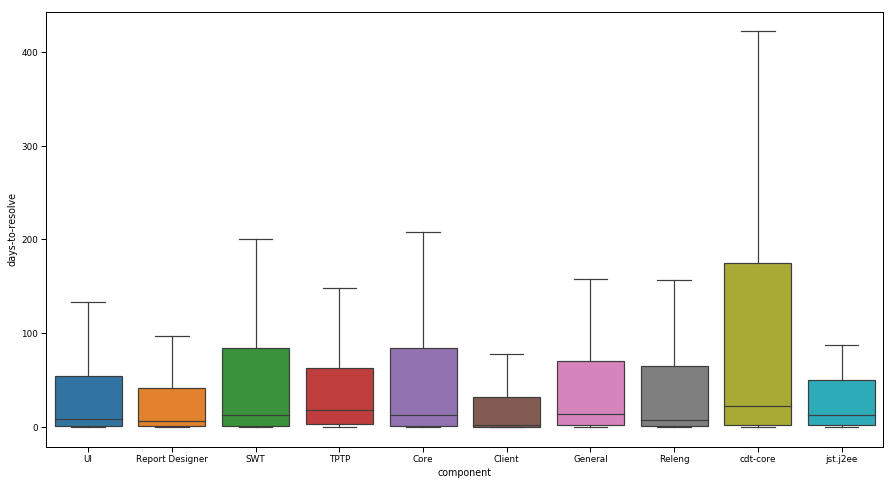

In [256]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['component'].isin(top_10_component.index)]
            , x="component"
            , y="days-to-resolve"
            , showfliers=False)

## 1.2 Experiment Analysis

In [6]:
import pandas as pd
import numpy as np
results = pd.read_csv('~/Workspace/issue-crawler/rscripts/results/20181125021535-long_live_bug-evaluation.csv')

# filling missing data
mean_of_acc1 = results['Acc_1'].mean()
results['Acc_1'] = results.Acc_1.fillna(mean_of_acc1)
results['Balanced_Acc'] = results.Balanced_Acc.fillna((results.Acc_0 + results.Acc_1) / 2)

# updating data 
results.loc[results['Model'] == 'knn', 'Model'] = 'KNN'
results.loc[results['Model'] == 'rf', 'Model']  = 'Random Forest'
results.loc[results['Model'] == 'svmRadial', 'Model'] = 'SVM'
features = ['Description','Description_Summary', 'Summary']
results = results[results.Feature.isin(features)]
results.head()

,Dataset,Model,Resampling,Distribution,Threshold,Train_Size,Train_Qt_Class_0,Train_Qt_Class_1,Test_Size,Test_Qt_Class_0,...,Tp,Fp,Tn,Fn,Acc_0,Acc_1,Balanced_Acc,Precision,Recall,Fmeasure
0,Eclipse,KNN,bootstrap,balanced,4,5804,2511,3293,1933,836,...,280,308,556,789,0.476190,0.413383,0.444787,0.476190,0.261927,0.337960
1,Eclipse,KNN,bootstrap,balanced,8,5803,3075,2728,1934,1025,...,518,485,507,424,0.516451,0.544576,0.530513,0.516451,0.549894,0.532648
2,Eclipse,KNN,bootstrap,balanced,12,5803,3318,2485,1934,1106,...,669,470,437,358,0.587357,0.549686,0.568521,0.587357,0.651412,0.617729
3,Eclipse,KNN,bootstrap,balanced,16,5803,3555,2248,1934,1185,...,773,468,412,281,0.622885,0.594517,0.608701,0.622885,0.733397,0.673638
4,Eclipse,KNN,bootstrap,balanced,20,5804,3702,2102,1933,1233,...,923,510,310,190,0.644103,0.620000,0.632052,0.644103,0.829290,0.725059


### Analysis of Results

In [7]:
# calculating ratio between classes.
results['Total_Ratio_Class_0'] = (results['Train_Qt_Class_0'] + results['Test_Qt_Class_0']) / (results['Train_Size']+results['Test_Size']) 
results['Total_Ratio_Class_1'] = (results['Train_Qt_Class_1'] + results['Test_Qt_Class_1']) / (results['Train_Size']+results['Test_Size']) 
results['Train_Ratio_Class_0'] = (results['Train_Qt_Class_0']) / (results['Train_Size']) 
results['Train_Ratio_Class_1'] = (results['Train_Qt_Class_1']) / (results['Train_Size']) 
results['Test_Ratio_Class_0']  = (results['Test_Qt_Class_0'])  / (results['Test_Size']) 
results['Test_Ratio_Class_1']  = (results['Test_Qt_Class_1'])  / (results['Test_Size']) 

results.head(10)

,Dataset,Model,Resampling,Distribution,Threshold,Train_Size,Train_Qt_Class_0,Train_Qt_Class_1,Test_Size,Test_Qt_Class_0,...,Balanced_Acc,Precision,Recall,Fmeasure,Total_Ratio_Class_0,Total_Ratio_Class_1,Train_Ratio_Class_0,Train_Ratio_Class_1,Test_Ratio_Class_0,Test_Ratio_Class_1
0,Eclipse,KNN,bootstrap,balanced,4,5804,2511,3293,1933,836,...,0.444787,0.476190,0.261927,0.337960,0.432597,0.567403,0.432633,0.567367,0.432488,0.567512
1,Eclipse,KNN,bootstrap,balanced,8,5803,3075,2728,1934,1025,...,0.530513,0.516451,0.549894,0.532648,0.529921,0.470079,0.529898,0.470102,0.529990,0.470010
2,Eclipse,KNN,bootstrap,balanced,12,5803,3318,2485,1934,1106,...,0.568521,0.587357,0.651412,0.617729,0.571798,0.428202,0.571773,0.428227,0.571872,0.428128
3,Eclipse,KNN,bootstrap,balanced,16,5803,3555,2248,1934,1185,...,0.608701,0.622885,0.733397,0.673638,0.612641,0.387359,0.612614,0.387386,0.612720,0.387280
4,Eclipse,KNN,bootstrap,balanced,20,5804,3702,2102,1933,1233,...,0.632052,0.644103,0.829290,0.725059,0.637844,0.362156,0.637836,0.362164,0.637869,0.362131
5,Eclipse,KNN,bootstrap,balanced,24,5804,3861,1943,1933,1286,...,0.667094,0.663758,0.871366,0.753524,0.665245,0.334755,0.665231,0.334769,0.665287,0.334713
6,Eclipse,KNN,bootstrap,balanced,28,7630,3977,3653,2542,1325,...,0.595190,0.720841,0.260359,0.382547,0.521235,0.478765,0.521232,0.478768,0.521243,0.478757
7,Eclipse,KNN,bootstrap,balanced,32,7522,4085,3437,2506,1361,...,0.611048,0.741235,0.309623,0.436793,0.543079,0.456921,0.543074,0.456926,0.543097,0.456903
8,Eclipse,KNN,bootstrap,balanced,64,8185,4612,3573,2728,1537,...,0.650772,0.827035,0.346740,0.488622,0.563456,0.436544,0.563470,0.436530,0.563416,0.436584
9,Eclipse,KNN,bootstrap,balanced,96,9547,4867,4680,3182,1622,...,0.687430,0.955140,0.249634,0.395817,0.509781,0.490219,0.509794,0.490206,0.509742,0.490258


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
    
def plot_line_by_models(data, title, feature, value, ylabel):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharex=True)
    def plot_line(_data, _title, _ax):
        plt.style.use('fast')
        sns.set_context("paper", font_scale=1.4)
        
        # Setting the figure's main title to the text passed as parameter
        fig.suptitle(title)
        ax = sns.lineplot(data=_data, markers=True, ax=_ax)
        ax.set_title(_title)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0,1.0)
        ax.set_xlim(0,512)
        ax.grid(axis='both',color='grey', linestyle=':', lw=0.5, alpha=0.5)

        return
    
    all_results = data[data['Feature'] == feature]
   
    bs_results  = all_results[all_results['Resampling'] == 'bootstrap']
    bs_results  = bs_results.pivot_table(index=['Threshold'], columns='Model', values=value)
    
    cv_results  = all_results[all_results['Resampling'] == 'cv52']
    cv_results  = cv_results.pivot_table(index=['Threshold'], columns='Model', values=value)
    
    #threshold_range_1 = range(4, 36, 4)
    #threshold_range_2 = range(64, 534, 32)
    #threshold_range   = list(threshold_range_1) + list(threshold_range_2)
    
    plot_line(bs_results, 'Sampling: Bootstrap', axes[0])
    plot_line(cv_results, 'Sampling: CV 5x2', axes[1])
    
    return fig, ax

### Feature: Description

(<Figure size 1440x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1858c550>)

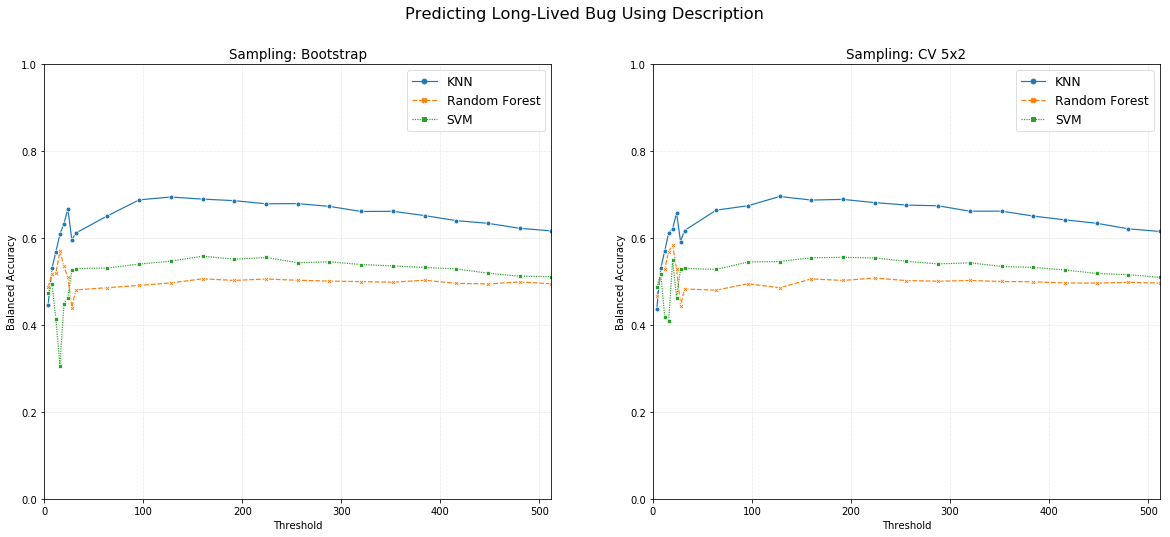

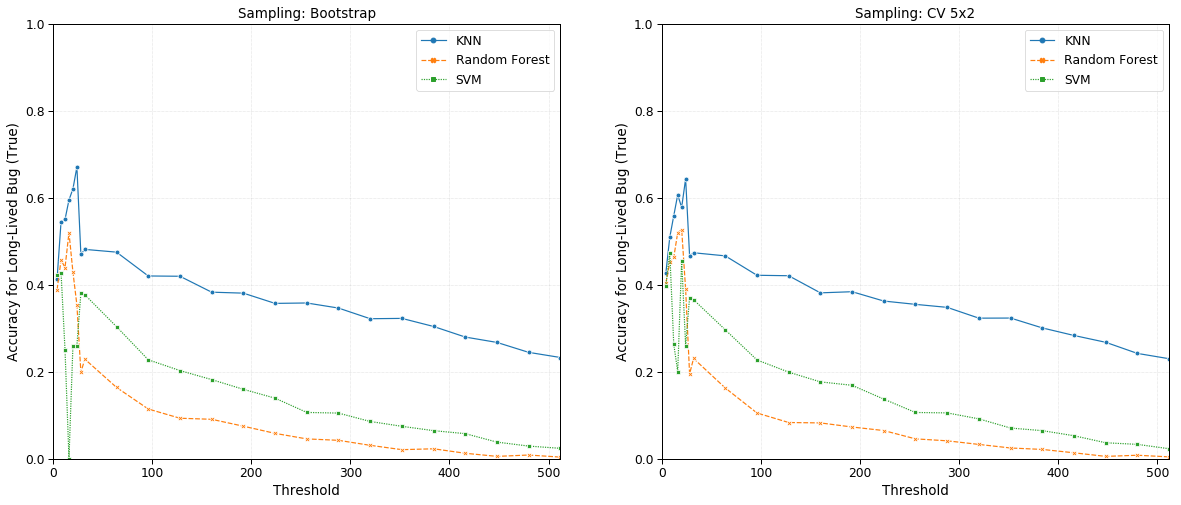

In [10]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Description', 'Description','Balanced_Acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'Description',  'Acc_1', 'Accuracy for Long-Lived Bug (True)')

Taking into account a reasonable threshold of up to 32 days, the **knn model** yielded the best accuracy value (**70.2%**) for both bootstrap and cross-validation.

Taking into account a reasonable threshold of up to **32 days**, the **random forest** model yielded the best accuracy values, **76.2%** for both bootstrap and **74.2%** for cross-validation resampling methods.

### Feature: Description + Summary

(<Figure size 1440x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a372b1ef0>)

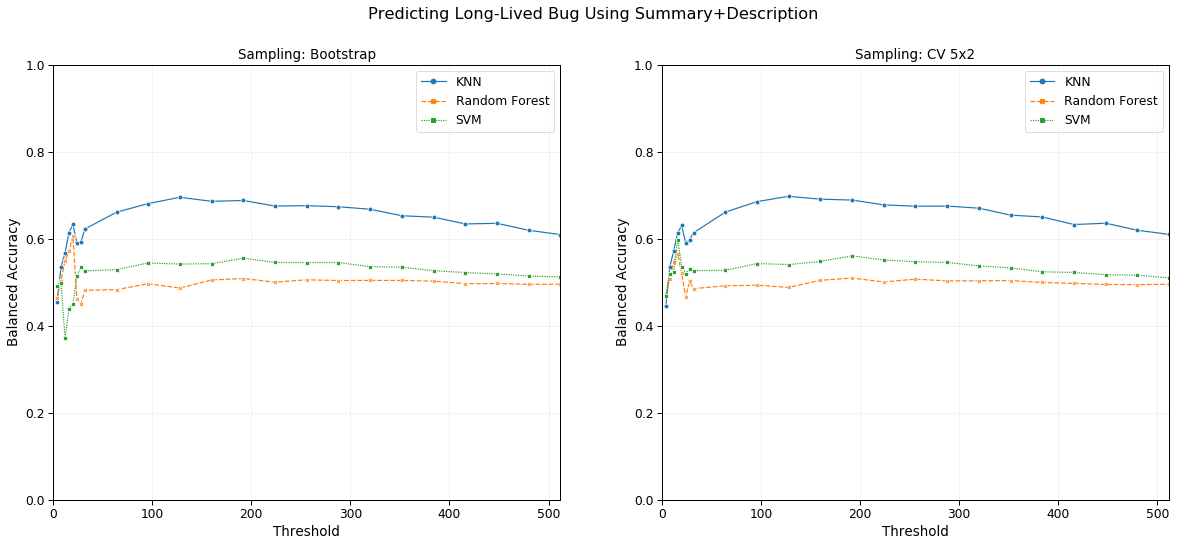

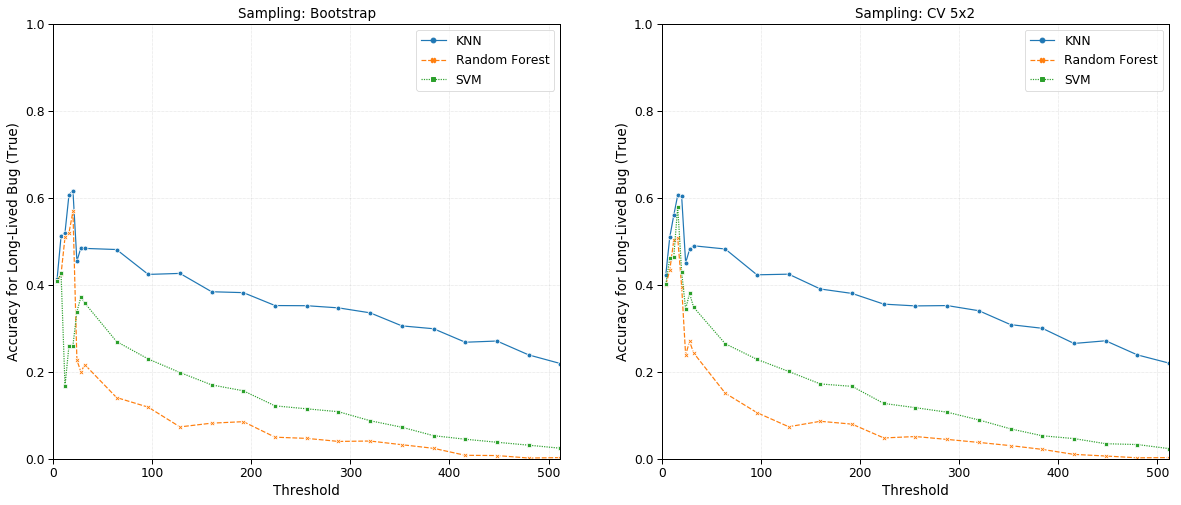

In [261]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Summary+Description', 'Description_Summary', 'Balanced_Acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'Description_Summary', 'Acc_1', 'Accuracy for Long-Lived Bug (True)')

### Feature: Summary

(<Figure size 1440x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a372b1ef0>)

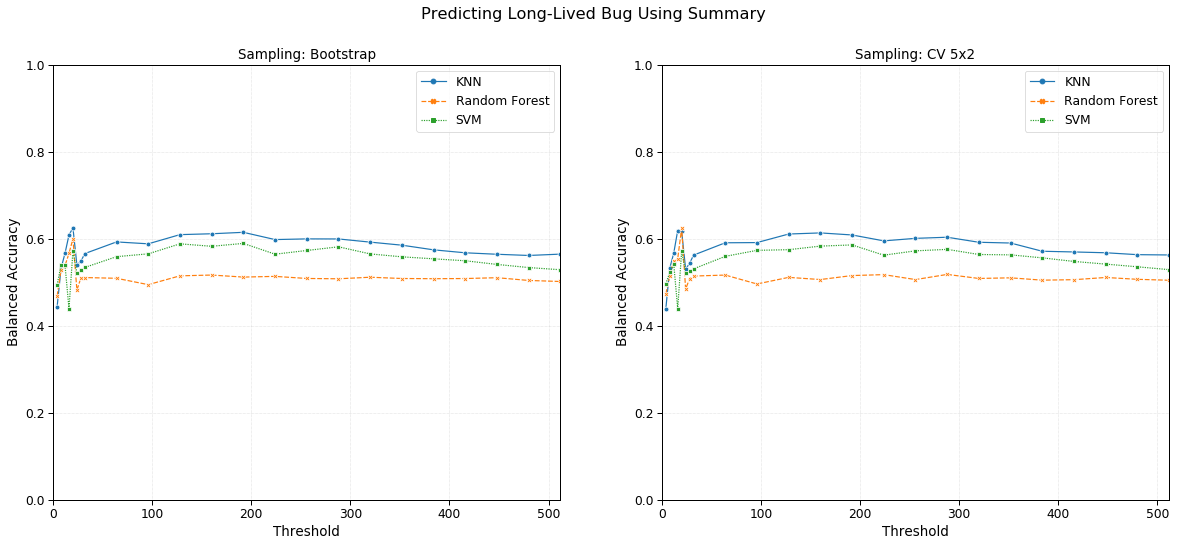

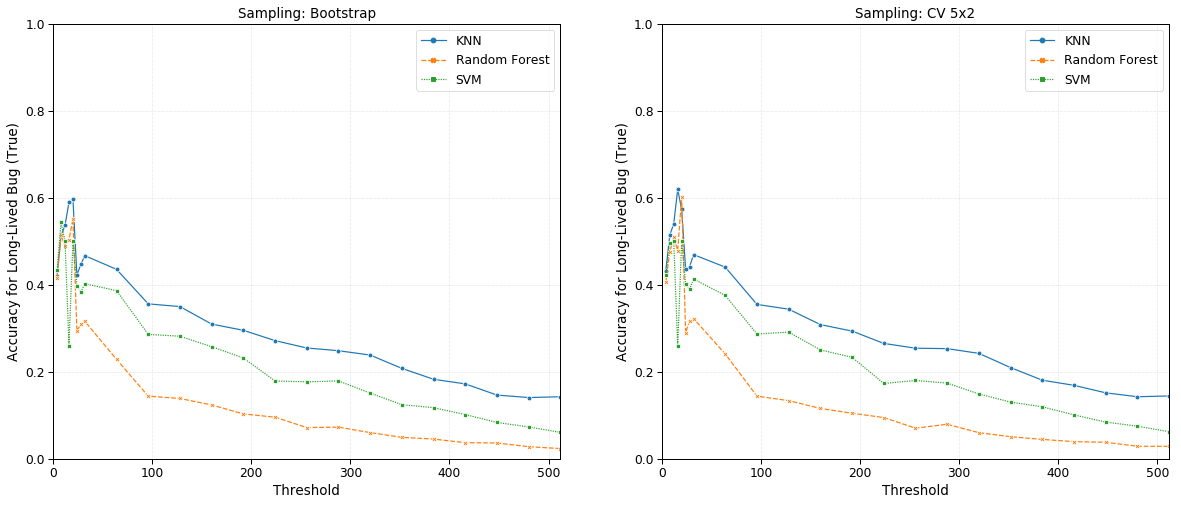

In [262]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Summary', 'Summary', 'Balanced_Acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'Summary', 'Acc_1', 'Accuracy for Long-Lived Bug (True)')

Taking into account a reasonable threshold of up to **32 days**, the **knn** model yielded the best accuracy values, **70.7**% for bootstrap and **70.6**% for cross-validation resampling methods.

### Class Ratio

(<Figure size 2000x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a36817470>)

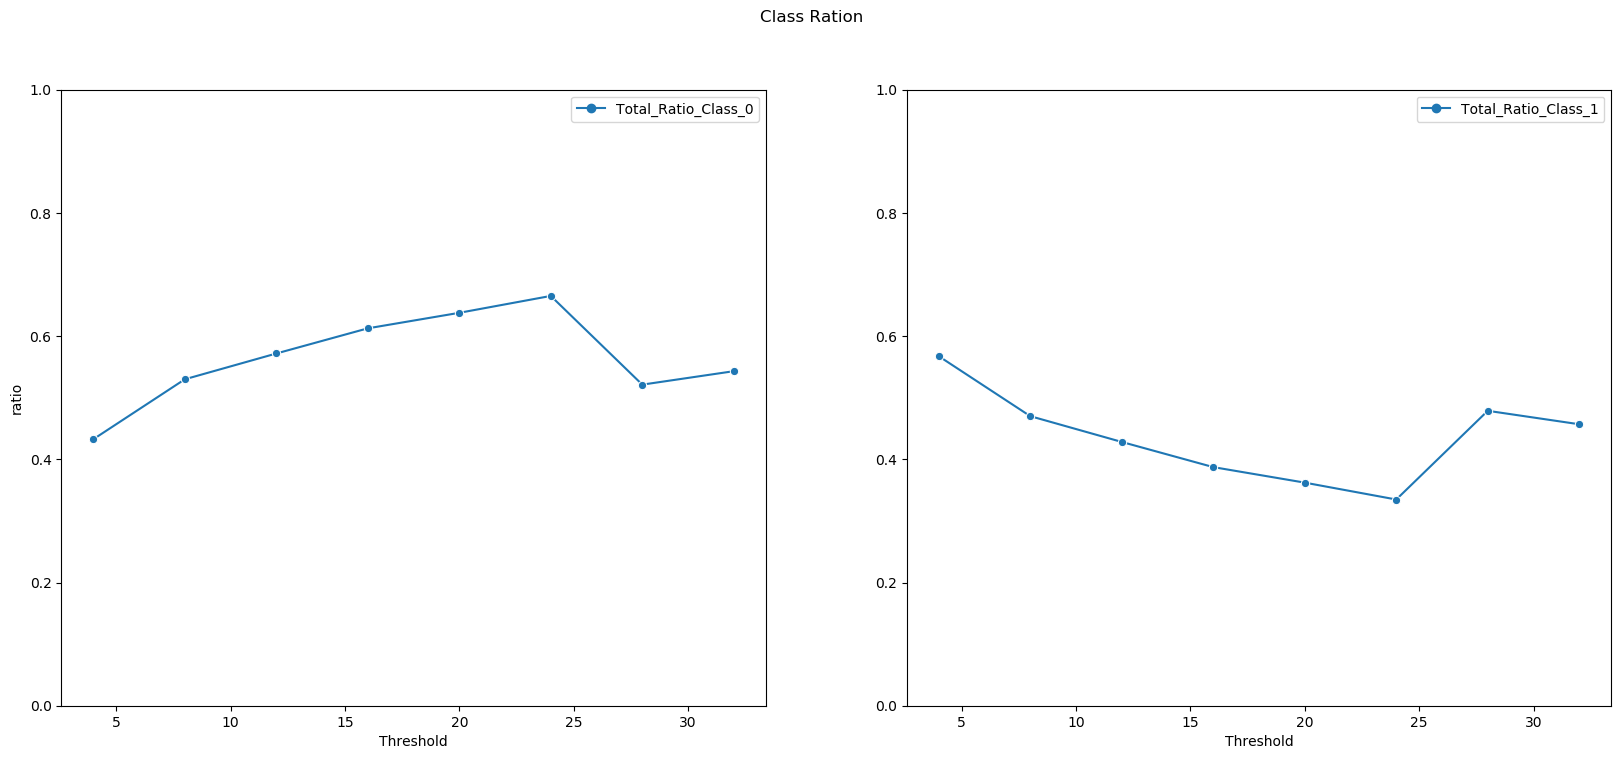

In [263]:
def plot_line_ratios(data):
    plt.style.use('default')

    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharex=True)
    ratios = results.iloc[0:8, ]
    ratios = ratios[['Threshold','Total_Ratio_Class_0','Total_Ratio_Class_1']]
   
    ratios_class_0  = ratios[['Threshold','Total_Ratio_Class_0']]
    ratios_class_1  = ratios[['Threshold','Total_Ratio_Class_1']]
    
    ratios_class_0.set_index('Threshold', inplace=True, drop=True)
    ratios_class_1.set_index('Threshold', inplace=True, drop=True)
  
    threshold_range_1 = range(4, 36, 4)
    threshold_range_2 = range(64, 534, 32)
    threshold_range   = list(threshold_range_1) + list(threshold_range_2)
    
    fig.suptitle('Class Ration')

    ax = sns.lineplot(data=ratios_class_0, markers=True, ax=axes[0])
    ax.set_ylabel('ratio')
    ax.set_ylim(0,1.0)

    ax = sns.lineplot(data=ratios_class_1, markers=True, ax=axes[1])
    ax.set_ylabel('')
    ax.set_ylim(0,1.0)
    
    return fig, ax

plot_line_ratios(results)
